# Random Forest 

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import validation_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score
from evaluation_utils import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

X_train = train.drop(columns='died')
X_test = test.drop(columns='died')
y_train = train.died
y_test = test.died

# Train baseline random forest model with default parameters

In [3]:
lasso_features = np.r_[1:16, 17:  18:35, 38:41, 43:46, 47, 49, 50:54, 56:71,
                       73:77, 79:81, 84:86, 87, 89, 93, 95, 97, 99:105, 107, 
                       109:111, 112:116, 118:120, 122, 124:140, 142:145, 
                       146:151, 152:156, 158, 160:162, 163:169, 173:175, 177, 
                       179:188, 189, 191, 194:197, 201, 204:208, 210:212, 213, 
                       216:218, 219, 221, 224, 226, 228, 230, 232:235, 236]

X_train = X_train.iloc[:, lasso_features]
X_test = X_test.iloc[:, lasso_features]

In [4]:
rf_base = RandomForestClassifier(random_state=670).fit(X_train, y_train)

train_precision, train_recall, _ = (
    precision_recall_curve(y_train, rf_base.predict_proba(X_train)[:, 1])
)
test_precision, test_recall, _ = (
    precision_recall_curve(y_test, rf_base.predict_proba(X_test)[:, 1])
)

train_auprc = auc(train_recall, train_precision)
test_auprc = auc(test_recall, test_precision)

print(round(train_auprc, 3))
print(round(test_auprc, 3))

1.0
0.453


In [5]:
# Set up k-fold validation set
k_folds = KFold(n_splits=5, shuffle=True, random_state=670)
splits = list(k_folds.split(X_train, y_train))

# Use Grid Search CV to tune hyperparameters
rf_mod = RandomForestClassifier(random_state=670)
param_grid = {'n_estimators': range(100, 500, 50),
              'max_depth': [2, 3, 4],
              'class_weight':['balanced', 'balanced_subsample']
             }
grid_search = GridSearchCV(rf_mod, 
                           param_grid=param_grid, 
                           cv=splits, 
                           scoring='average_precision')
grid_search.fit(X_train, y_train)

# Get best parameters from Grid Search
print(grid_search.best_params_)

train_auprc = grid_search.score(X_train, y_train)
test_auprc = grid_search.score(X_test, y_test)

print(round(train_auprc, 3))
print(round(test_auprc, 3))

{'class_weight': 'balanced_subsample', 'max_depth': 4, 'n_estimators': 250}
0.509
0.398


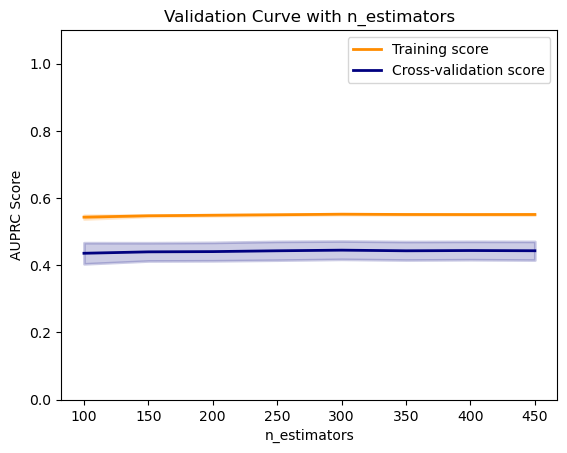

In [7]:
# Plot grid search CV results for n_estimators
plot_validation_curves(model=RandomForestClassifier(max_depth=4,
                                                    random_state=670), 
                       param_range=range(100, 500, 50), 
                       data=X_train, 
                       target=y_train, 
                       param_name='n_estimators', 
                       scoring='average_precision', 
                       cv=splits, 
                       ylabel='AUPRC Score')

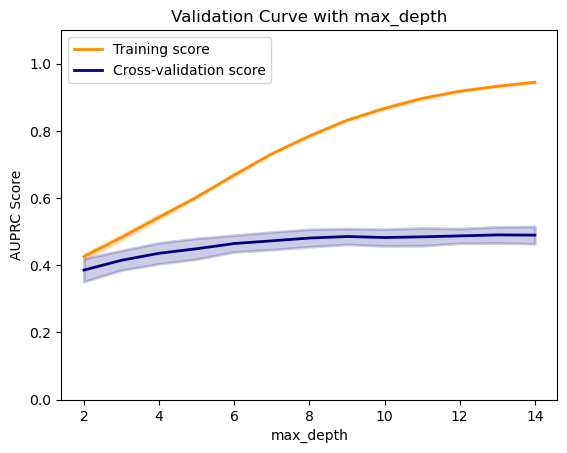

In [8]:
# Plot grid search CV results for max depth
plot_validation_curves(model=rf_mod, 
                       param_range=range(2, 15, 1), 
                       data=X_train, 
                       target=y_train, 
                       param_name='max_depth', 
                       scoring='average_precision', 
                       cv=splits, 
                       ylabel='AUPRC Score')

### Evaluate final model 

In [11]:
train_pred_probs = grid_search.predict_proba(X_train)[:, 1]
test_pred_probs = grid_search.predict_proba(X_test)[:, 1]

train_results = compute_metrics(train_pred_probs, y_train)
test_results = compute_metrics(test_pred_probs, y_test)

print(train_results)
print(test_results)

    threshold  precision    recall  f-score
47       0.47   0.273473  0.801899  0.57838
    threshold  precision    recall   f-score
48       0.48   0.280835  0.730864  0.553478


In [4]:
train_lasso = X_train.copy()
test_lasso = X_test.copy()

train_lasso['died'] = y_train
test_lasso['died'] = y_test

rf_final_mod = RandomForestClassifier(n_estimators=250,
                                      max_depth=4,
                                      class_weight='balanced_subsample',
                                      random_state=670)

bootstrap_model_metrics(model=rf_final_mod, 
                        train_data=train_lasso, 
                        test_data=test_lasso, 
                        target_col='died', 
                        n_boot_samples=500)

95% CI for train AUPRC: (0.5467415415842898, 0.5916769000302625)
95% CI for train precision: (0.29493319201497914, 0.397375986847043)
95% CI for train recall: (0.7029563233376792, 0.8207859629014722)
95% CI for train F-score: (0.5925879127536747, 0.6251042958272102) 

95% CI for test AUPRC: (0.33921703918939317, 0.45854437856013486)
95% CI for test precision: (0.2166833547647479, 0.3216199461896451)
95% CI for test recall: (0.6914328136168432, 0.8559919631862078)
95% CI for test F-score: (0.5192206759690308, 0.5893977933618705)
